This cell imports all of the necessary libraries for the code to run properly.

In [1]:
import random
from platform import python_version as pythonversion
from matplotlib import __version__ as matplotlibversion
import numpy as np # bunch of math functions very commonly used
import matplotlib # plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numericalunits as nu
import wimprates
import math
import tqdm

from multihist import Histdd # lovely 2D histogram package

The four cells below calculate the velocity and energy value propabilities for use in the main function below. Using the wimprates function, a propability density function (PDF) is created, and from that, a cumulative distribution function (CDF) is calculated so that a uniform propability in a unit range can be used to give out a velocity value and an energy value (each individually and and mostly independently) given the propabilities of the energies within the calculated range.

In [16]:
def Vel_makeCDF():
    v_Vals = np.linspace(0,1000000,1000)
    Vel_Dist = wimprates.observed_speed_dist(v_Vals * nu.m/nu.s)
    
    integrated_Vel_rate = sum([x*((max(v_Vals)-min(v_Vals))/len(v_Vals)) for x,y in zip(Vel_Dist,v_Vals)])
    vel_PDF = np.array(Vel_Dist)/integrated_Vel_rate
    vel_CDF = [sum(vel_PDF[:i])/sum(vel_PDF) for i in range(len(vel_PDF))]
    return v_Vals, vel_CDF

def Vel_Calc(v_Vals,vel_CDF):
    
    rndUntNum_Vel = np.random.uniform()
    Vel_index = np.argmin(abs(np.array(vel_CDF) - rndUntNum_Vel))
    Vel = v_Vals[Vel_index]
    
    return Vel

In [3]:
def Int_Enr(Vel):
    m_n = 131*nu.amu
    unit_vel = Vel*nu.m/nu.s

    set_of_energies = np.linspace(0.01,2*m_n*(unit_vel**2)/nu.keV,1000)
    formfactor_distribution = wimprates.helm_form_factor_squared(set_of_energies*nu.keV)

    integrated_Enr_values = sum([x*((max(set_of_energies)-min(set_of_energies))/len(set_of_energies)) for x in formfactor_distribution])

    FF_PDF = np.array(formfactor_distribution)/integrated_Enr_values
    FF_CDF = [sum(FF_PDF[:i])/sum(FF_PDF) for i in range(len(FF_PDF))]
    
    return(FF_CDF, set_of_energies)
    
    #Below is the code for plotting the data here

In [4]:
#plt.figure(figsize=[12,8])
#plt.plot(E_Vals,PDF)
#plt.plot([E_thresh,E_thresh],[min(rate),max(rate)])
#plt.title('Total rate = '+str(integrated_rate))
#plt.yscale('log')
#plt.ylabel('Probability')
#plt.xlabel('Energy deposited (keV)')
#plt.show()

In [5]:
#plt.plot(set_of_energies,FFPDF)
#plt.yscale('log')
#plt.show()

#OR

#plt.plot(set_of_energies,1-np.array(FFCDF))
#plt.yscale('log')
#plt.show()

In [6]:
def Energy_Calc(CDF, E_Vals):
    rndUntNum = np.random.uniform()
    index = np.argmin(abs(np.array(CDF) - rndUntNum))
    EnrDep = E_Vals[index]
    return EnrDep

The cells below open the photon yield text file and convert the data within the file into an array for use in the following function.

In [7]:
pyieldfile = open('photonyield_NR.txt','r')
pyieldData = pyieldfile.readlines()
pyieldfile.close()

In [8]:
ph_yields=[]
for line in pyieldData:
    line = line.strip('\r\n')
    line = line.split(', ')
    ph_yields.append([float(line[0]),float(line[1])])

phList = np.array(ph_yields)
#print(List)

The cells below open the electron yield text file and convert the data within the file into an array for use in the following function.

In [9]:
cyieldfile = open('chargeyield_NR.txt','r')
cyieldData = cyieldfile.readlines()
cyieldfile.close()

In [10]:
ch_yields=[]
for line in cyieldData:
    line = line.strip('\r\n')
    line = line.split(', ')
    ch_yields.append([float(line[0]),float(line[1])])

chList = np.array(ch_yields)
#print(List)

This function calculates the number of s1 photons and the number of s2 electrons that are produced during an interaction for a given energy.

In [11]:
def s1_s2_Calcs(E):
    phIndex=np.argmin(np.abs(phList[:,0] - E))
    s1Phs = int(round(E * phList[phIndex,1]))

    chIndex=np.argmin(np.abs(chList[:,0] - E))
    s2Elcts = int(round(E * chList[chIndex,1]))
    
    return s1Phs, s2Elcts

The cell block below is taken almost exactly from the previous waveform notebook (Waveform simulation explanation), and it is intended to calculate the different paths through the TPC that a particle going in a straight line would produce. The code randomly determines starting and ending points on the cylinder for each vector considered, and, for the purposes of this notebook, it makes sure that these vector lines are within the window that is appropriate for our measurements in the z direction (-0.5 < z < 0.45). The main useful results of this code are the value for nMax (which is the number of vectors created in one cell run), the coordinates of the starting and ending points in three dimensions, and the unit vector of each created line. Of course, the whole cell is very important because it is vital in the creation of these vector lines and the determination of whether they are appropriatly passing through the TPC.

The findXY function produces random x and y values from a given z value and from a few other previously calculated variables (such as the unit vector), these themselves randomly generated. The do math function then calculates the values for the coordinate points on the cylinder (TPC) given all of the previous variables, calculations, and set constrictions. Starting after the 'List of Lists' section, the determination portion of the code begins, where the vectors are determined to either be valid hits, pass through the dead zone, or be complete misses. The portions of the do_math function calls for any other determinations other than the 'hits' have been commented out because they are unnecessary for the purposes of this notebook.

In [25]:
# Edited on 10/29/18 
# Iteration 4 - plot the sample waveforms based on the simulations
# Plane 1 is at z=-.5
# Plane 2 is at z=.47
# Plane 3 is at z=.5
# Opposite of "dead" is "safe"

#zTop and zBottom refer to the actual z-coordinates where the event intersected the TPC
#z2Top and z2Bottom are the distances from zTop and zBottom from the top of the TPC (i.e. z2Top=.5-zTop)


rad = 1 # Radius of surrounding sphere.  In theory increasing this ...
# ... should not affect the proportion of those thru the TPC that don't pass thru the dead zone. (sqrt(2) is min)
nMax = 10000 # Fires a larger number of particles, but more accurate

# Pick random point on sphere
def sample_spherical(npoints=1, ndim=3):
    vec = np.random.randn(ndim, npoints) # mean 0 and std.dev. 1
    vec /= np.linalg.norm(vec, axis=0) # Normalizes by magnitude
    return vec*rad # Multiply by radius of sphere

# Finds x,y values from given z value and line vectors
def findXY(z,r0,v0):
    x = float(v0[0]/v0[2]*(z-r0[2]) + r0[0])
    y = float(v0[1]/v0[2]*(z-r0[2]) + r0[1])
    return(x,y)

# Finds whether the given x,y position is in the infinite cylinder of radius .5
def in_cylinder(x,y):
    if(x**2+y**2 < .5**2):
        return True
    else:
        return False

def do_math(z1,z2,r0,v0,safe=True):
    
     
    # x,y position of where cylinder was hit
    cylXYOne = findXY(z1,r0,v0)
    cylXYTwo = findXY(z2,r0,v0)

    # x,y,z position of where cylinder was hit
    cylPosOne = np.array([cylXYOne[0],cylXYOne[1],z1])
    cylPosTwo = np.array([cylXYTwo[0],cylXYTwo[1],z2])
    
    points1_all.append(cylPosOne)
    points2_all.append(cylPosTwo)

    lenThruCyl = np.linalg.norm(cylPosOne-cylPosTwo) # Magnitude of track length
    deltaZ = abs(z1-z2) # Change in z-value

    zTop = max(z1, z2) # Larger z COORDINATE
    zBot = min(z1, z2) # Smaller z COORDINATE

    z2Top = .5-zTop # Distance from higher z to top of TPC
    z2Bot = .5-zBot # Distance from lower z to top of TPC
        
    

#####################################################################################

# LIST OF LISTS

#####################################################################################
    
numThruTPC = 0 # Number of events that passed thru TPC
numThruTPCButNotDeadZone = 0 # Number of events that passed thru TPC and did NOT pass thru dead zone
horiz_hits = 0 # Number of hits that passed thru the lateral cylinder surface on both entrance and exit
bottom_hits = 0 # Number of hits that either entered or exited through the cylinder base
lengthsAll = [] # All track lengths
deltaZAll = [] # All distances b/w enter and exit z-coordinates
lengthsSafe = [] # Safe track lenghts
deltaZSafe = [] # Safe distances b/w enter and exit z-coordinates
z2Tops = [] # Safe distances b/w higher z coordinate and top of TPC
z2Bottoms = [] # Safe distances b/w lower z coordinate and top of TPC
z2TopsAll = [] # All distances b/w higher z coordinate and top of TPC
z2BottomsAll = [] # All distances b/w lower z coordinate and top of TPC

points1_all = []
points2_all = []
v0_all = []
pathlen_all = []

# The following are only calculated for "safe" data:
s1Areas = [] # Areas of s1 (pe)
s2Areas = [] # Areas of s2 (pe)
s2Widths = [] # Widths of s2 (us)
t1s = [] # (us) times for s1 to occur SINCE t=0 (defined as beginning of event)
t2s = [] # (us) times SINCE t=0 for s2 to START
t3s = [] # (us) times SINCE t=0 for s2 to END
A1s = [] # Amplitudes of s2 (pe/bin)
bathtubWidths = [] # (us) Time differences b/w end of s1 and start of s2


n=0

#for n in range(0,nMax):    # n particles are shot
while n < nMax:
    miss = False
    dead = False
    r0 = sample_spherical()
    r1 = sample_spherical()
    pathLength = np.linalg.norm(r1-r0)
    v0 = (r1-r0) / pathLength
    
    
    
    # Find the 2 points where this line intersects the vertical infinite cylinder of radius .5
    # Use symmetric equations (x-x0)/a = (y-y0)/b = (z-z0)/c for r(t)=(x0,y0,z0)+t(a,b,c)
    # Equation of infinite cylinder is x^2+y^2 = (1/2)^2
    # Solve this equation for z, given initial position and velocity vectors
    a = v0[0]/v0[2]
    b = r0[0] - v0[0]/v0[2]*r0[2]
    c = v0[1]/v0[2]
    d = r0[1] - v0[1]/v0[2]*r0[2]
    coeffs = float(a**2 + c**2), float(2*(a*b+c*d)), float(b**2 + d**2 - 1/4)
    zVals = np.roots(coeffs) # Values of z where cylinder was crossed
    #print(zVals)
    if isinstance(zVals[0],complex): # Complex roots means cylinder was missed
#        print('Missed cylinder')
        h=0
    else:
        # Finds whether the lines pass through planes 1, 2, and 3 within the cylinder or not
        plane1XY = findXY(-.5,r0,v0)
        p1In = in_cylinder(plane1XY[0],plane1XY[1])
        plane2XY = findXY(.47,r0,v0)
        p2In = in_cylinder(plane2XY[0],plane2XY[1])
        plane3XY = findXY(.5,r0,v0)
        p3In = in_cylinder(plane3XY[0],plane3XY[1])
#        print(p1In,p2In,p3In)
        
        # Logic for determining hits, deads, and misses
        if not(p1In) and not(p2In) and not(p3In):
            if ((-.5<zVals[0]<.47) and (-.5<zVals[1]<.47)): #hit     
                numThruTPC += 1
                numThruTPCButNotDeadZone += 1
                horiz_hits += 1
#############                     
                do_math(max(zVals[0],zVals[1]),min(zVals[0],zVals[1]),r0,v0) # HORIZONTAL SAFE HIT

                n += 1
                v0_all.append(v0)
                #pathlen_all.append(pathLength)
#############            
            elif ((.47<zVals[0]<.5) and (.47<zVals[1]<.5)): #hit,dead
                numThruTPC += 1
                dead = True
                
                #do_math(max(zVals[0],zVals[1]),min(zVals[0],zVals[1]),r0,v0,False) # HORIZONAL DEAD HIT
                
            else: #miss high or miss low
                miss = True
#                print('Missed vertically')
        elif p1In and not(p2In) and not(p3In): #hit
                numThruTPC += 1
                numThruTPCButNotDeadZone += 1
                bottom_hits += 1
#############                     
                do_math(max(zVals[0],zVals[1]),-.5,r0,v0) # BOTTOM CORNER SAFE HIT
    
                n += 1
                v0_all.append(v0)
                #pathlen_all.append(pathLength)
############# 
        else: #hit,dead
            numThruTPC += 1
            dead = True
            if not(p1In) and p2In and not(p3In): continue
                #do_math(max(zVals[0],zVals[1]),min(zVals[0],zVals[1]),r0,v0,False) # HORIZONTAL DEAD HIT
                
            elif (p1In and p2In and not(p3In)): continue
                #do_math(max(zVals[0],zVals[1]),-.5,r0,v0,False) # BOTTOM CORNER DEAD HIT
                
            elif p1In and p2In and p3In: continue
                #do_math(.5,-.5,r0,v0,False) # VERTICAL DEAD HIT
                
            else: continue
                #do_math(.5,min(zVals[0],zVals[1]),r0,v0,False) # UPPER CORNER DEAD HIT
                

                
if numThruTPC != 0:    
    efficiency = numThruTPCButNotDeadZone/numThruTPC
    percThru = numThruTPC/nMax
    propBottom = bottom_hits/(bottom_hits+horiz_hits)
    print('Efficiency:',efficiency)
    print('Proportion through TPC:',percThru)
    print('Proportion safe hits thru z=-.5m:',propBottom)
else:
    print('div0')

Efficiency: 0.6532532009406846
Proportion through TPC: 1.5308
Proportion safe hits thru z=-.5m: 0.4284


This cell executes all of the main functions of this note, primarily resulting in the updated arrays of values that would be placed in a text file to be fed into FAX for simulation. This cell first calculates the s1 and s2 values given g1, g2, W, and E (from the cell above) values, as well as a ratio that would split the energy between the two signals. We are also assuming here a monochromatic signal for all of the interactions (thus, similar velocities, masses, etc. for the particles). This cell then creates all of the necessary lists/arrays that the values of will be required in the output text file, those being the instruction number, the recoil type, the X, Y, and Z values, the s1 and s2 values, and the time. The X, Y, and Z values are the coordinate points of each interaction within each instruction (which represents essentially one particle line vector). There are 0 to nMax possible vectors and, thus, instructions, and within each instruction there are 0 to intNum possible interactions. The value for nMax is currently arbitrary, and the value for intNum for each instruction is randomly generated, but these can be set to any value, possibly following some set/given distribution or limit. The line vector path length is also calculated here so that the X, Y, and Z coordinate values of each interaction can be determined. These cordinate values are set to be equidestant from each other throughout the vector within the cylinder (TPC), but their distance from each other can be randomly set or they can be determined based on some specific distribution generation. Given that the cell above always had points1 higher than points2 for a given vector, we here had to make sure that the unit vector was directed/pointing correctly by setting the starting point to either be points1 or points2. The cell then appends all of the lists, and the next interactions are calculated, followed by the following instructions and their individual interactions. Also, the time value resets for each event/instruction.

In [26]:
g1 = 1     #0.1426    # 0.1426 +- 0.0001 +- 0.0017 Pe/Ph
g2 = 1     #11.55     # 11.55 +- 0.01 +- 0.24 Pe/e
W = 13.7       # in eV
Rt1 = 0.5
Rt2 = 1 - Rt1
intNum = 2
t0 = 500000 # Nanoseconds
crSect = 1e-23 # cm^2
row = 3.1 # g per cm^3
MrM = 131 #g per mol
Na = 6.02e23 #number per mol

vVals, VCDF = Vel_makeCDF()

numDen = row * Na / MrM # number per cm^3

intProb = numDen * crSect * 100  # interaction per m

instructions = []
recoil_type = []
X = []
Y = []
Z = []
S1 = []
S2 = []
T = []
D = []
point = [0, 0, 0]
tlD = 0


for i in tqdm.trange(0,nMax):
    
    D = np.sqrt((points1_all[i][0]-points2_all[i][0])**2+(points1_all[i][1]-points2_all[i][1])**2+(points1_all[i][2]-points2_all[i][2])**2)
    
    Vel = Vel_Calc(vVals,VCDF)
    CDF, E_Vals = Int_Enr(Vel)
        
    j = 0
    tlD = 0
    
    #This is interaction level
    while (1):    
        # Calculating the coordinate point locations
        d = random.expovariate(intProb)
        tlD += d
        
        if tlD > D:
            break
        
        # Calculates the energy using the energy calculation cells
        E = Energy_Calc(CDF, E_Vals)
        
        # Calculates the s1 Photon and s2 electrons from the s1_s2 calculation cells and files
        s1Phs, s2Elcts = s1_s2_Calcs(E)
        
        if v0_all[i][2][0] < 0:
            Strt_point = points1_all[i]
        else:
            Strt_point = points2_all[i]

        for k in range(0,3):
            if j == 0:
                point[k] = Strt_point[k] + (d * v0_all[i][k][0])
            else:
                point[k] += d * v0_all[i][k][0]
        
        # Appending list values with calculated results
        X.append((point[0] * 100 * 47.9) / 50) # append (the x-comp * metric conversion * (scale factor - a/b))
        Y.append((point[1] * 100 * 47.9) / 50) # append (the x-comp * metric conversion * (scale factor - a/b))
        Z.append((50 - (point[2] * 100 )) * 0.969) # append ((scale factor - a/b) - the x-comp * metric conversion)
        instructions.append(i)
        recoil_type.append('NR')
        S1.append(s1Phs)
        S2.append(s2Elcts)
        T.append(t0 + (tlD * 1e6 * 1000 / Vel))
        
        j += 1

/depot/darkmatter/apps/wimprates/wimprates.py:48: RuntimeWarning: divide by zero encountered in true_divide
  xmax = np.minimum(1, (v_esc**2 - v_earth**2 - v**2)/(2 * v_earth * v))
100%|██████████| 10000/10000 [1:16:30<00:00,  2.18it/s]


The two cells below show us the coordinate values that are created and if they are actually within the correct bounds of the TPC. The histograms can take in any two of the coordinate planes (X, Y, and/or Z), and some interesting plots for the distribution of the vectors result (including the vector lines).

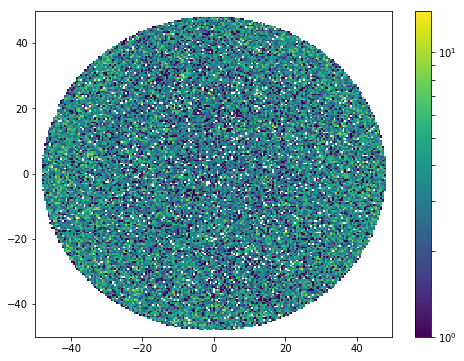

In [27]:
fig, ax = plt.subplots(figsize=[8,6])
plt.hist2d(X,Y,bins=[np.linspace(-50,50,200),np.linspace(-50,50,200)],norm=clr.LogNorm())
#plt.xlim(-55,55)
#plt.ylim(100,0)
#plt.ylim(-55,55)
plt.colorbar()
plt.show()

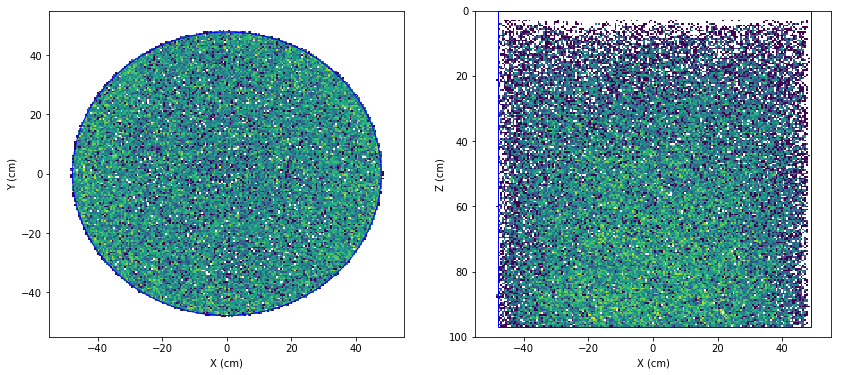

In [28]:
fig, axs = plt.subplots(1,2,figsize = [14,6])
ax = axs[0]
ax.hist2d(X,Y,bins=[np.linspace(-55,55,200),np.linspace(-55,55,200)],norm=clr.LogNorm())
#ax.set_xlim(-55,55)
#plt.ylim(-55,55)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
circle1 = plt.Circle((0, 0), 47.8, edgecolor='b', fill=False)
ax.add_artist(circle1)

ax = axs[1]
ax.hist2d(X,Z,bins=[np.linspace(-55,55,200),np.linspace(0,100,200)],norm=clr.LogNorm())
ax.set_ylim(100,0)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
Rect1 = plt.Rectangle((-47.9,0), 96.9, 96.9, edgecolor='b', fill=False)
ax.add_artist(Rect1)

#plt.savefig('')
plt.show()

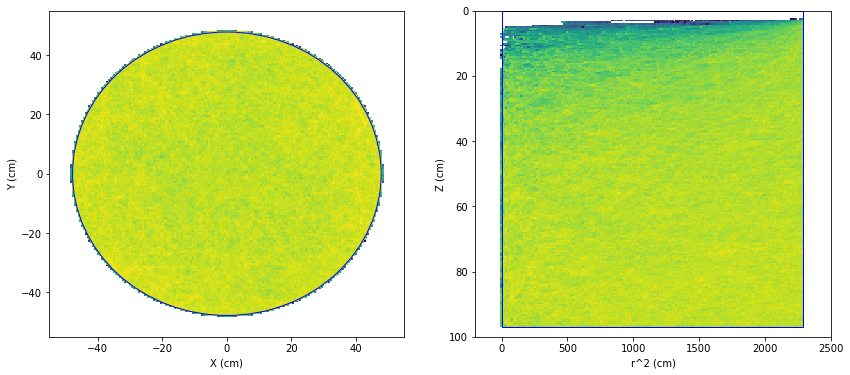

In [20]:
fig, axs = plt.subplots(1,2,figsize = [14,6])
ax = axs[0]
ax.hist2d(X,Y,bins=[np.linspace(-55,55,200),np.linspace(-55,55,200)],norm=clr.LogNorm())
#ax.set_xlim(-55,55)
#plt.ylim(-55,55)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
circle1 = plt.Circle((0, 0), 47.8, edgecolor='b', fill=False)
ax.add_artist(circle1)

ax = axs[1]
Xry = np.array(X)
Yry = np.array(Y)
r = Xry**2 + Yry**2
ax.hist2d(r,Z,bins=[np.linspace(-200,2500,200),np.linspace(0,100,200)],norm=clr.LogNorm())
ax.set_ylim(100,0)
ax.set_xlabel('r^2 (cm)')
ax.set_ylabel('Z (cm)')
Rect1 = plt.Rectangle((0,0), 47.9**2, 96.9, edgecolor='b', fill=False)
ax.add_artist(Rect1)

#plt.savefig('')
plt.show()

The following cells update the text file which is to be input into FAX.

In [29]:
f = open('Testsigma_1e-23.csv','w')

In [30]:
f.write('instruction,recoil_type,x,y,depth,s1_photons,s2_electrons,t\n')
for ri in range(0,len(instructions)):
    f.write(str(instructions[ri])+','+str(recoil_type[ri])+','+str(X[ri])+','+str(Y[ri])+','+str(Z[ri])+','+str(S1[ri])+','+str(S2[ri])+','+str(T[ri])+'\n')

In [31]:
f.close()

This cell creates an easily readable table with the values created, although it does not run for really big nMax's (so, many vectors/events).

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
col_labels = ['Instructions', 'Recoil Type', 'X', 'Y', 'Z', 'S1', 'S2', 'Time-Diff']

table_vals=[]

for i in range(0,len(instructions)):
    table_vals.append([instructions[i], recoil_type[i], X[i], Y[i], Z[i], S1[i], S2[i], T[i]])

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.1] * 8,
#rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(15)
the_table.scale(8, 4)

#Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.savefig('nice-table.png', bbox_inches='tight', pad_inches=0.05)

This cell is just for checking purposes.

In [101]:
for i in range(len(points1_all)):
    z = points1_all[i][2]
    z2 = points2_all[i][2]
    vz = v0_all[i][2][0]
    #if vz > 0:
    #    continue
    #elif vz < 0:
    #    continue
    #else:
    #    print('horiz')
    if z > z2:
        print('right')

right
right
right
right
right
right
right
right
right
right
